# Concat Attention Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re

## Loading the Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ass-28/ita.txt', delimiter = "\t",names = ["english","italian","z"]).drop("z",axis=1)
df

,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?
...,...,...
345239,"If you want to sound like a native speaker, yo...","Se vuoi sembrare un madrelingua, devi essere d..."
345240,"If you want to sound like a native speaker, yo...","Se vuoi sembrare un madrelingua, devi essere d..."
345241,If someone who doesn't know your background sa...,Se qualcuno che non conosce il tuo background ...
345242,Doubtless there exists in this world precisely...,Senza dubbio esiste in questo mondo proprio la...


## Preprocess Data

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def preprocessor(text):
    text = text.lower()
    text = decontracted(text)
    text = re.sub("[^A-Za-z0-9 ]+",'',text)
    return text
def preprocessor_ita(text):
    text = text.lower()
    text = decontracted(text)
    text = re.sub("[^A-Za-z0-9 ]+",'',text)
    return text


In [5]:
# PREPROCESSED DATA INTO A DATAFRAME
df["english"] = df.english.apply(preprocessor)
df["italian"] = df.italian.apply(preprocessor_ita)
df

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi
...,...,...
345239,if you want to sound like a native speaker you...,se vuoi sembrare un madrelingua devi essere di...
345240,if you want to sound like a native speaker you...,se vuoi sembrare un madrelingua devi essere di...
345241,if someone who does not know your background s...,se qualcuno che non conosce il tuo background ...
345242,doubtless there exists in this world precisely...,senza dubbio esiste in questo mondo proprio la...


In [6]:
# REMOVING SENTENCES WITH LENGTH GREATER THAN 20
df["eng_len"] = df.english.apply(lambda x: len(x.split()))
df = df[df.eng_len<=20]
df["ita_len"] = df.italian.apply(lambda x: len(x.split()))
df  = df[df.ita_len<=20]
# ADDING <start> TO THE BEGINING OF ENGLISH SENTENCES
df["english_inp"]= "<start> "+ df.english
df["english_out"]= df.english+ " <end>"
df.drop(["english","eng_len","ita_len"],axis=1,inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>
...,...,...,...
344915,charles moore cre il forth nel tentativo di au...,<start> charles moore created forth in an atte...,charles moore created forth in an attempt to i...
344998,se la tua azienda opera principalmente con lam...,<start> if your company primarily does busines...,if your company primarily does business with a...
344999,se la sua azienda opera principalmente con lam...,<start> if your company primarily does busines...,if your company primarily does business with a...
345000,se la vostra azienda opera principalmente con ...,<start> if your company primarily does busines...,if your company primarily does business with a...


 ## Train Test Split

In [2]:
from sklearn.model_selection import train_test_split

In [8]:
train , validation = train_test_split(df,test_size = 0.2,random_state=33)
#ADDING <end> RO THE END OF FIRST ENGLISH SENTENCE IN "english_inp"
train.iloc[0]["english_inp"]  = train.iloc[0]["english_inp"] + " <end>"

## Tokenization

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
# TOKENIZE ENGLISH SENTENCES
tk_eng = Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tk_eng.fit_on_texts(train.english_inp.values)
# TOKENIZING ITALIAN SENTENCES
tk_ita = Tokenizer()
tk_ita.fit_on_texts(train.italian)

## Data Generator

In [4]:
from  tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
class Dataset :
    def __init__(self, data,tk_eng,tk_ita,max_len):
        self.encoder_inp = data["italian"].values
        self.decoder_inp = data["english_inp"].values
        self.decoder_out = data["english_out"].values
        self.tk_eng = tk_eng
        self.tk_ita = tk_ita
        self.max_len = max_len
        
    def __getitem__(self,i):
        # ITALIAN TO INTEGER SEQUENCES
        self.encoder_seq = self.tk_ita.texts_to_sequences([self.encoder_inp[i]])
        # ENGLISH TO INTEGER SEQUENCES 
        self.decoder_inp_seq = self.tk_eng.texts_to_sequences([self.decoder_inp[i]])
        # ENGLISH TO INTEGER SEQUENCES
        self.decoder_out_seq = self.tk_eng.texts_to_sequences([self.decoder_out[i]])
        
        # PADDING THE ENCODER INPUT SEQUENCES
        self.encoder_seq = pad_sequences(self.encoder_seq,maxlen = self.max_len,padding="post")
        # PADDING THE DECODER INPUT SEQUENCES
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq,maxlen = self.max_len,padding = "post")
        # PADDING DECODER OUTPUT SEQUENCES
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq,maxlen = self.max_len,padding = "post")
        return self.encoder_seq ,  self.decoder_inp_seq,  self.decoder_out_seq
    
    def __len__(self):
        # RETURN THE LEN OF INPUT ENDODER
        return len(self.encoder_inp)

In [13]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self,batch_size,dataset):
        # INTIALIZING THE REQUIRED VARIABLES 
        self.dataset = dataset
        self.batch_size = batch_size
        self.totl_points = self.dataset.encoder_inp.shape[0]
        
    def __getitem__(self,i):
        # STATING THE START AND STOP VATIABLE CONTAINGING INDEX VALUES FOR EACH BATCH
        start = i * self.batch_size
        stop = (i+1)*self.batch_size
        
        # PLACEHOLDERS FOR BATCHED DATA
        batch_ita =[]
        batch_eng_input = []
        batch_eng_out =[]

        for j in range(start,stop): # FOR EACH VALUE IN START TO STOP 
            
            a,b,c = self.dataset[j] # DATASET RETURNS ITALIAN , ENGLIGH_INPUT, ENGLISH_OUTPUT
            batch_ita.append(a[0]) # APPENDING ITALIAN TO batch_ita
            batch_eng_input.append(b[0]) # APPENGIND ENGLISH INPUT TO batch_eng_input
            batch_eng_out.append(c[0]) # APPENDING ENGLISH OUTPUT TO batch_eng_out
        
        # Conveting list to array   
        batch_ita = (np.array(batch_ita)) 
        batch_eng_input = np.array(batch_eng_input)
        batch_eng_out = np.array(batch_eng_out)
        
        return [batch_ita , batch_eng_input],batch_eng_out
    
    def __len__(self):
        # Returning the number of batches
        return int(self.totl_points/self.batch_size)

## Encoder

In [5]:
from tensorflow.keras import layers

In [17]:
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    
    def __init__(self, vocab_size,emb_dims, enc_units, input_length,batch_size):
        super().__init__()
        # INITIALIZING THE REQUIRED VARIABLES
        self.batch_size=batch_size # BATHCH SIZE
        self.enc_units = enc_units # ENCODER UNITS

        # EMBEDDING LAYER
        self.embedding= layers.Embedding(vocab_size ,emb_dims) 
        # LSTM LAYER WITH RETURN SEQ AND RETURN STATES
        self.lstm = layers.LSTM(self.enc_units,return_state= True,return_sequences =  True) 
    def call(self, enc_input , states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        # FORMING THE EMBEDDED VECTOR 
        emb = self.embedding(enc_input)
        # PASSING THE EMBEDDED VECTIO THROUGH LSTM LAYERS 
        enc_output,state_h,state_c = self.lstm(emb,initial_state=states)
        #RETURNING THE OUTPUT OF LSTM LAYER
        return enc_output,state_h,state_c 

    def initialize(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        return tf.zeros(shape=(batch_size,self.enc_units)),tf.zeros(shape=(batch_size,self.enc_units))

### Encoder Check

In [18]:
vocab_size=10
embedding_size=20
lstm_size=32
input_length=10
batch_size=16

enc = Encoder(vocab_size,embedding_size,lstm_size,input_length,batch_size)
a,b,c = enc(tf.random.uniform((batch_size,input_length)),enc.initialize(batch_size))
print("ENCODER OUTPUT SHAPE=",a.shape)
print("ENCODER STATE H SHAPE=",b.shape)
print("ENCODER STATE C SHAPE=",c.shape)

ENCODER OUTPUT SHAPE= (16, 10, 32)
ENCODER STATE H SHAPE= (16, 32)
ENCODER STATE C SHAPE= (16, 32)


## Attention  for Concat Model

In [21]:
# THIS IS ATTNETION LAYER FOR DOT MODEL
class Attention(tf.keras.layers.Layer):
    '''THIS FUNCTION RETURNS THE CONTEXT VECTOR AND ATTENTION WEIGHTS (ALPHA VALUES)'''
    def __init__(self,units):
        super().__init__()
        # INITIALIZING THE DENSE LAYER W1
        self.W1 = layers.Dense(units)
        # INITIALIZING THE DENSE LAYER W2
        self.W2 = layers.Dense(units)
        # INITIALIZING THE DENSE LAYER V
        self.v = layers.Dense(1)
        
    def call(self,enc_output,dec_state):
        # EXPANDING THE DIMENSION OF DECODER STATE  EG. FROM (16,32) TO (16,32,1)
        dec_state =  tf.expand_dims(dec_state,axis=1)
        
        # FINDING THE SCORE FOR CONCAT MODEL
        score = self.v(tf.nn.tanh(
            self.W1(dec_state)+ self.W2(enc_output)
        ))
        # APPLYING SOFTMAX TO THE AXIS 1
        # OUPUT SHAPE = (16,13,1)
        att_weights = tf.nn.softmax(score,axis=1)
        
        # CALCULATING THE CONTEXT VECTOR BY FIRST ELEMENTWISE MULTIPLICATION AND THEN ADDING THE AXIS 1
        # (16,13,1)*(16,13,32)=(16,13,32)
        context_vec  = att_weights* enc_output
        
        # (16,13,32) SUM AND REDUCE THE DIMENSION AT AXIS 1 => (16,32)
        context_vec = tf.reduce_sum(context_vec,axis=1)
        
        # RETURNING THE CONTEXT VECTOR AND ATTENTION WEIGHTS
        return context_vec,att_weights

### Attention Check

In [22]:
input_length=10
batch_size=16
att_units=32

att = Attention(att_units)
encoder_output =  tf.random.uniform((batch_size,input_length,att_units))
dec_state_h=tf.random.uniform(shape=[batch_size,att_units])
x1, x2 = att(encoder_output,dec_state_h)
print("CONTEXT VECTOR SHAPE=",x1.shape)
print("ATTENTION WEIGHTS SHAPE=",x2.shape)

CONTEXT VECTOR SHAPE= (16, 32)
ATTENTION WEIGHTS SHAPE= (16, 10, 1)


## One Step Decoder

In [26]:
class Onestepdecoder(tf.keras.Model):
    '''THIS MODEL OUTPUTS THE RESULT OF DECODER FOR ONE TIME SETP GIVEN THE INPUT FOR PRECIOVE TIME STEP'''
    
    def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size):
        super().__init__()
        # INTITALIZING THE REQUIRED VARIABLES
        # EMBEDDING LAYERS
        self.emb = layers.Embedding(vocab_size,emb_dims,input_length= input_len)
        # ATTENTION LAYER
        self.att = Attention(att_units)
        # LSTM LAYER
        self.lstm = layers.LSTM(dec_units,return_sequences=True,return_state=True)
        # DENSE LAYER
        self.dense = layers.Dense(vocab_size)

    def call(self, encoder_output , input , state_h):
        # FORMING THE EMBEDDED VECTOR FOR THE WORD
        # (32,1)=>(32,1,12)
        emb = self.emb(input)
        
        # GETTING THE CONTEXT VECTOR AND ATTENTION WEIGHTS BASED ON THE ENCODER OUTPUT AND PREVIOUS DECODER STATE_H
        context_vec,alphas = self.att(encoder_output,state_h)
        
        # CONCATINATING THE CONTEXT VECTOR(BY EXPANDING DIMENSION) AND ENBEDDED VECTOR
        # (32,1,16)|(32,1,12)=>(32,1,28)
        dec_input =  tf.concat([tf.expand_dims(context_vec,1),emb],axis=-1)
        
        # PASSING THE CONTEXT VECTOR THROUGH LSTM UNIT
        dec_output,dec_state_h,state_c = self.lstm(dec_input)
        
        # PASSING THE DECODER OUTPUT THROUGH DENSE LAYER WITH UNITS EQUAL TO VOCAB SIZE
        fc = self.dense(dec_output)
        
        # RETURNING THE OUTPUT
        return fc , dec_state_h , alphas

### One step Decoder Check

In [27]:
tar_vocab_size=13 
embedding_dim=12 
input_length=10
dec_units=16 
att_units=16
batch_size=32

onestepdecoder=Onestepdecoder(tar_vocab_size, embedding_dim, input_length, dec_units , att_units , batch_size)
input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
state_h=tf.random.uniform(shape=[batch_size,dec_units])

output,state_h,attention_weights=onestepdecoder(encoder_output,input_to_decoder,state_h)

print("one_step_dec output shape",output.shape)
print("state_h",state_h.shape)
print("attention_weight",attention_weights.shape)

one_step_dec output shape (32, 1, 13)
state_h (32, 10)
attention_weight (32, 10, 1)


## Decoder

In [29]:
class Decoder(tf.keras.Model):
    '''THIS MODEL PERFORMS THE WHOLE DECODER OPERATION FOR THE COMPLETE SENTENCE'''
    def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size):
        super().__init__()
        # INITIALIZING THE VARIABLES
        # LENGTH OF INPUT SENTENCE
        self.input_len = input_len
        # ONE STEP DECODER
        self.onestepdecoder = Onestepdecoder(vocab_size,emb_dims, dec_units, input_len,att_units,batch_size)

    def call(self,dec_input,enc_output,state_h):
        # THIS VATIABLE STORES THE VALUE OF STATE_H FOR THE PREVIOUS STATE
        current_state_h = state_h 
        # THIS STORES THE DECODER OUTPUT FOR EACH TIME STEP
        pred = []
        # THIS STORED THE ALPHA VALUES
        alpha_values = []
        # FOR EACH WORD IN THE INPUT SENTENCE
        for i in range(self.input_len):
            
            # CURRENT WORD TO INPUT TO ONE STEP DECODER
            current_vec = dec_input[:,i]
            # EXPANDING THE DIMENSION FOR THE WORD
            current_vec = tf.expand_dims(current_vec,axis=-1)
            # PERFORMING THE ONE STEP DECODER OPERATION 
            dec_output,dec_state_h,alphas = self.onestepdecoder(enc_output ,current_vec,current_state_h)
            #UPDATING THE CURRENT STATE_H
            current_state_h = dec_state_h
            #APPENDING THE DECODER OUTPUT TO "pred" LIST
            pred.append(dec_output)
            # APPENDING THE ALPHA VALUES
            alpha_values.append(alphas)
            
        # CONCATINATING ALL THE VALUES IN THE LIST
        output = tf.concat(pred,axis=1)
        # CONCATINATING ALL THE ALPHA VALUES IN THE LIST
        alpha_values = tf.concat(alpha_values,axis = -1)
        # RETURNING THE OUTPUT
        return output , alpha_values


### Decoder Check

In [30]:
out_vocab_size=13 
embedding_dim=12 
input_length=11
dec_units=16 
att_units=16
batch_size=32
target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
state_h=tf.random.uniform(shape=[batch_size,dec_units])

decoder =Decoder(out_vocab_size, embedding_dim,dec_units , input_length, att_units,batch_size )
output,alpha_values = decoder(target_sentences,encoder_output, state_h)
print("Decoder Output=",output.shape)
print("Alpha Values=",alpha_values.shape)

Decoder Output= (32, 11, 13)
Alpha Values= (32, 11, 11)


## Encoder Decoder 

In [32]:
class encoder_decoder(tf.keras.Model):
    '''THIS MODEL COMBINES ALL THE LAYERS AND FORM IN ENCODER DECODER MODEL WITH ATTENTION MECHANISM'''
    def __init__(self,enc_vocab_size,enc_emb_dim,enc_units,enc_input_length,
             dec_vocab_size,dec_emb_dim,dec_units,dec_input_length ,att_units, batch_size):
        # INITAILIZING ALL VARIABLES
        super().__init__()
        # BATCH SIZE
        self.batch_size = batch_size
        # INITIALIZING ENCODER LAYER
        self.encoder = Encoder(enc_vocab_size, enc_emb_dim,enc_units, enc_input_length,batch_size)
        # INITALIZING DECODER LAYER
        self.decoder = Decoder(dec_vocab_size ,dec_emb_dim,dec_units,dec_input_length  ,att_units, batch_size)

    def call(self,data):
        # THE INPUT OF DATALOADER IS IN A LIST FORM FOR EACH BATCH IT GIVER TWO INPUTS
        # INPUT1 IS FOR ENCODER
        # INPUT2 IS FOR DECODER
        inp1 , inp2 = data
        # PASSING THE INPUT1 TO ENCODER LAYER
        enc_output, enc_state_h, enc_state_c = self.encoder(inp1,self.encoder.initialize(self.batch_size))
        # PASSING INPUT2 TO THE DECODER LAYER
        dec_output , alphas = self.decoder(inp2 , enc_output,enc_state_h)
        # THE OUTPUT OF MODEL IS ONLY DECODER OUTPUT THE ALPHA VALUES ARE IGNORED HERE
        return dec_output



### Model Check

In [33]:
enc_vocab_size=13
enc_emb_dim=12
enc_units=16
enc_input_length=10
dec_vocab_size=13
dec_emb_dim=12
dec_units=16
dec_input_length=10
batch_size=32
att_units=16

e_d = encoder_decoder(enc_vocab_size,enc_emb_dim,enc_units,enc_input_length,
                      dec_vocab_size,dec_emb_dim,dec_units,dec_input_length, att_units,batch_size)

data1 = tf.random.uniform(shape=[batch_size , enc_input_length])
data2 = tf.random.uniform(shape=[batch_size , dec_input_length])
output = e_d([data1,data2])
print("MODEL OUPUT",output.shape)

MODEL OUPUT (32, 10, 13)


In [240]:
# FORMING THE BATCHED DATASET FOR TRAIN DATA
train_dataset = Dataset(train,tk_eng,tk_ita,20)
train_dataloader = Dataloader( batch_size = 1000 , dataset=train_dataset)
#FORMING THE BATCHED DATASET FOR TEST DATA
val_dataset = Dataset(validation,tk_eng,tk_ita,20)
val_dataloader = Dataloader(batch_size=1000,dataset=val_dataset)

In [243]:
# INITAILZING THE MODEL
model = encoder_decoder(enc_vocab_size=len(tk_ita.word_index)+1,
                         enc_emb_dim = 50,
                         enc_units=512,enc_input_length=20,
                         dec_vocab_size =len(tk_eng.word_index)+1,
                         dec_emb_dim =50,
                         dec_units=512,
                         dec_input_length = 20,
                         
                         att_units=512,
                         batch_size=1000)

In [60]:
# TRAIN STEPS
train_steps = train_dataloader.__len__()
# VALIDATION STEPS
val_steps  = val_dataloader.__len__()
# CALLBACKS FOR SAVING THE MODEL
callback = [tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/ass-28/test_save1/best.h5","val_loss",verbose=1,save_best_only=True,save_weights_only=True)
            ]
# COMPILIG THE MODEL WITH ADAM OPTIMIZER AND LOSS AS SPARSE CROSS ENROPY WITH LOGITS EQUAL TO TRUE
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none" ))
# FITTING THE MODEL
model.fit(train_dataloader, steps_per_epoch=train_steps,epochs= 50,validation_data = val_dataloader,validation_steps =val_steps,callbacks=callback)

Epoch 1/50
275/275 [==============================] - 237s 850ms/step - loss: 1.6695 - val_loss: 1.5051

Epoch 00001: val_loss improved from inf to 1.50513, saving model to /content/drive/MyDrive/Colab Notebooks/ass-28/test_save1/best.h5
Epoch 2/50
275/275 [==============================] - 233s 849ms/step - loss: 1.3547 - val_loss: 1.2033

Epoch 00002: val_loss improved from 1.50513 to 1.20327, saving model to /content/drive/MyDrive/Colab Notebooks/ass-28/test_save1/best.h5
Epoch 3/50
275/275 [==============================] - 234s 852ms/step - loss: 1.1213 - val_loss: 1.0546

Epoch 00003: val_loss improved from 1.20327 to 1.05455, saving model to /content/drive/MyDrive/Colab Notebooks/ass-28/test_save1/best.h5
Epoch 4/50
275/275 [==============================] - 234s 850ms/step - loss: 0.9851 - val_loss: 0.9380

Epoch 00004: val_loss improved from 1.05455 to 0.93799, saving model to /content/drive/MyDrive/Colab Notebooks/ass-28/test_save1/best.h5
Epoch 5/50
275/275 [================

In [245]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/ass-28/test_save1/best.h5")

## Prediction

In [246]:
def predict(ita_text,model):
    '''THIS FUNCTION IS USED IN INFERENCE TIME WHICH GIVEN ANY SENTENCE IN ITALIAN OUTPUTS THE ENGLISH SENTENCE AND ALPHA VALUES'''
    # FORMING TOKENIZED SEQUENCES FOR INPUT SENTENCE
    seq = tk_ita.texts_to_sequences([ita_text])
    
    # PADDING THE SEQUENCES
    seq = pad_sequences(seq,maxlen = 20 , padding="post")
    
    # INITIALIZING THE STATES FOR INPUTING TO ENCODER
    state = model.layers[0].initialize(1)
    
    # GETTING THE ENCODED OUTPUT
    enc_output,state_h,state_c= model.layers[0](seq,state)
    
    
    # VARIABLE TO STORE PREDICTED SENTENCE
    pred = []
    
    # THIS VARIABLE STORES THE STATE TO BE INPUTED TO ONE STEP ENCODER
    input_state_h = state_h
    input_state_c = state_c
    
    # THIS VARIABLE STORES THE VECTOR TO VE INPUTED TO ONE STEP ENCODER
    current_vec = tf.ones((1,1))
    # THIS VARIABLE WILL STORE ALL THE ALPHA VALUES OUTPUTS
    alpha_values = []
    
    for i in range(20):
        # PASSING THE REQUIRED VARIABLE TO ONE STEP ENCODER LAYER
        fc , dec_state_h , alphas = model.layers[1].layers[0](enc_output , current_vec ,input_state_h )
        #APPENDING THE ALPHA VALUES TO THE LIST "alpha_values"
        alpha_values.append(alphas)
        
        # UPDATING THE CURRENT VECTOR 
        current_vec = np.argmax(fc , axis = -1)
        # UPDATING THE INPUT STATE
        input_state_h = dec_state_h
        # GETTING THE ACTUAL WORDS FRO THE TOKENIZED INDEXES
        pred.append(tk_eng.index_word[current_vec[0][0]])
        # IF THE WORD "<end>" COMES THE LOOP WILL BREAK
        if tk_eng.index_word[current_vec[0][0]]=="<end>":
              break
    # JOINING THE PREDICTED WORDS
    pred_sent = " ".join(pred)
    
    # CONCATINATING ALL THE ALPHA VALUES
    alpha_values = tf.squeeze(tf.concat(alpha_values,axis=-1),axis=0)
    
    # RETURNING THE PREDICTED SENTENCE AND ALPHA VALUES
    return  pred_sent , alpha_values

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot( input_sent , output_sent , alpha ) :
    '''THIS FUNCTION PLOTS THE ALPHA VALUES IN FORM OF HEAT MAPS'''
    
    input_words = input_sent.split() # SPLITTING THE INPUT SENTENCE
    output_words = output_sent.split() # SPLITTING THE OUTPUT SENTENCE
    
    fig, ax = plt.subplots()
    sns.set_style("darkgrid")
    # HEAT MAP WITH ALPHA VALURS 
    # X LABELS ARE THE OUTPUT WORDS 
    # T LABELS ARE THE INPUT WORDS
    sns.heatmap(alpha, xticklabels= output_words , yticklabels=input_words,linewidths=0.01)
    # PLACING THE TICKS ON  THE TOP
    ax.xaxis.tick_top( ) 
    plt.show()

### Predinting Some Random Results

Input=> avevo il jet lag
Predicted=> i had jet lag <end>
Actual=> i had jet lag <end>


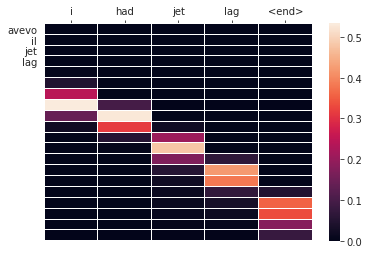

In [248]:
random = np.random.randint(0,2000,1)[0]
print("Input=>",validation.italian.values[random])
print("Predicted=>", predict( validation.italian.values[random] , model)[0])
print("Actual=>",validation.english_out.values[random])
print("="*50)
plot( validation.italian.values[random] , predict( validation.italian.values[random] , model)[0], predict( validation.italian.values[random] , model)[1] )

Input=> lui  seduto di fianco a suo fratello
Predicted=> he sat next to his brother <end>
Actual=> he was sitting side by side with his brother <end>


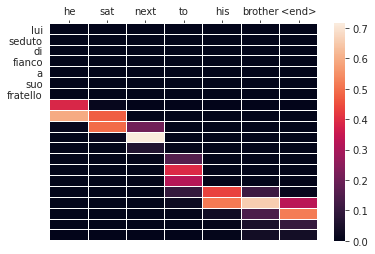

In [249]:
random = np.random.randint(0,2000,1)[0]
print("Input=>",validation.italian.values[random])
print("Predicted=>", predict( validation.italian.values[random] , model)[0])
print("Actual=>",validation.english_out.values[random])
print("="*50)
plot( validation.italian.values[random] , predict( validation.italian.values[random] , model)[0], predict( validation.italian.values[random] , model)[1] )

Input=> lui sembra forte
Predicted=> he looks strong <end>
Actual=> he looks strong <end>


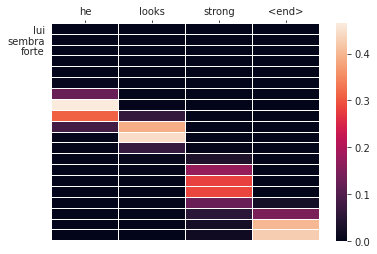

In [250]:
random = np.random.randint(0,2000,1)[0]
print("Input=>",validation.italian.values[random])
print("Predicted=>", predict( validation.italian.values[random] , model)[0])
print("Actual=>",validation.english_out.values[random])
print("="*50)
plot( validation.italian.values[random] , predict( validation.italian.values[random] , model)[0], predict( validation.italian.values[random] , model)[1] )

Input=> io sono arrabbiato con lei
Predicted=> i am angry with you <end>
Actual=> i am angry with you <end>


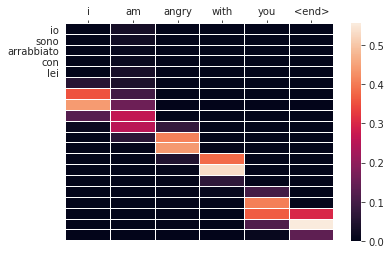

In [251]:
random = np.random.randint(0,2000,1)[0]
print("Input=>",validation.italian.values[random])
print("Predicted=>", predict( validation.italian.values[random] , model)[0])
print("Actual=>",validation.english_out.values[random])
print("="*50)
plot( validation.italian.values[random] , predict( validation.italian.values[random] , model)[0], predict( validation.italian.values[random] , model)[1] )

Input=>  allergico alla polvere domestica
Predicted=> are you wearing my knee than i win <end>
Actual=> he is allergic to house dust <end>


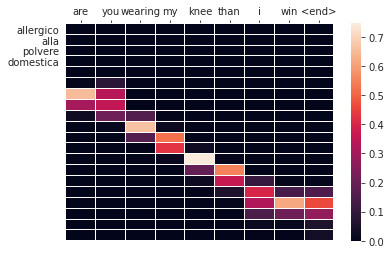

In [252]:
random = np.random.randint(0,2000,1)[0]
print("Input=>",validation.italian.values[random])
print("Predicted=>", predict( validation.italian.values[random] , model)[0])
print("Actual=>",validation.english_out.values[random])
print("="*50)
plot( validation.italian.values[random] , predict( validation.italian.values[random] , model)[0], predict( validation.italian.values[random] , model)[1] )

Input=> tom ha tagliato a fette la mela
Predicted=> tom sliced the apple to <end>
Actual=> tom sliced the apple <end>


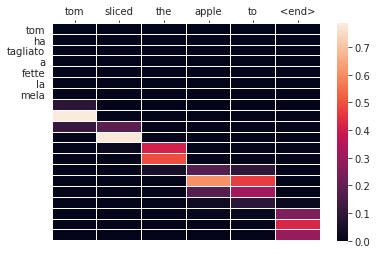

In [253]:
random = np.random.randint(0,2000,1)[0]
print("Input=>",validation.italian.values[random])
print("Predicted=>", predict( validation.italian.values[random] , model)[0])
print("Actual=>",validation.english_out.values[random])
print("="*50)
plot( validation.italian.values[random] , predict( validation.italian.values[random] , model)[0], predict( validation.italian.values[random] , model)[1] )

## BLEU Score for Concat Model

In [254]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [255]:
BLEU = []

test_data = validation.loc[np.random.choice(validation.index,size = 1000)][["italian","english_out"]]
for ind,i in tqdm(test_data.iterrows()):
    pred = predict(i.italian , model)[0]
    act = i.english_out
    b =bleu.sentence_bleu(act,pred)
    BLEU.append(b)

print("BLEU DOT Score = ",np.mean(BLEU))

1000it [02:18,  7.20it/s]

BLEU DOT Score =  0.8375976272129612
